# Module 9: Anomaly Detection

- The following tutorial contains Python examples for detecting anomalies (outliers) from data.

- [Introduction to Data Mining CH 09](http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial9/tutorial9.ipynb)

Anomaly detection is the task of identifying instances whose characteristics differ significantly from the rest of the data.

In this tutorial, we will provide examples of applying different anomaly detection techniques using Python and its library packages.

# 9.1 Using Parametric Models

This approach assumes that the majority of the data instances are governed by some well-known probability distribution, e.g., Binomial or Gaussian distribution. 

Anomalies can then detected by seeking for observations that do not fit the overall distribution of the data.

In this example, our goal is to detect anomalous changes in the daily closing prices of various stocks.

The nput data stocks.csv contains the historical closing prices of stocks for 3 large corporations (Microsoft, Fordotor Company, and Bank of America).

In [1]:
import pandas as pd

stocks = pd.read_csv('stocks.csv', header='infer' )
stocks.index = stocks['Date']
stocks = stocks.drop(['Date'],axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


 Compute the percentage of changes in the daily closing price of each stock as follows:
 
 $$
 \Delta(t) = 100 \times \frac{x_t-x_{t-1}}{x_{t-1}}
 $$
 
 where $x_t$ denotes the price of a stock on day t and $x_{t-1}$ denotes the price on its previous day, $t-1$.

In [4]:
import numpy as np

N,d = stocks.shape
delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values), columns=stocks.columns, index=stocks.iloc[1:].index)
delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


 Plot the distribution of the percentage daily changes in stock price

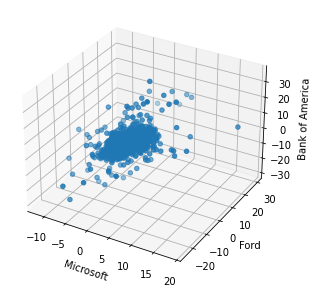

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,5)).gca(projection='3d')
fig.scatter(delta.MSFT,delta.F,delta.BAC)
fig.set_xlabel('Microsoft')
fig.set_ylabel('Ford')
fig.set_zlabel('Bank of America')
plt.show()

Assuming the data follows a multivariate Gaussian distribution, we can compute the mean and covariance matrix of the 3-dimensional data as follows

In [6]:
meanValue = delta.mean()
covValue = delta.cov()
print(meanValue)
print(covValue)

MSFT    0.045003
F       0.061374
BAC     0.033351
dtype: float64
          MSFT         F        BAC
MSFT  3.191674  2.136351   2.788870
F     2.136351  8.524944   4.997405
BAC   2.788870  4.997405  13.770761


To determine the anomalous trading days, we can compute the Mahalanobis distance between the percentage of price change on each day against the mean percentage of price change.


$Mahalanobis(x) = (x-\overline x)\sum^{-1}(x-\overline x)^T$

where is assumed to be a row vector.

See Equation 9.4 in Section 9.3.1 for more information about using Mahalanobis distance for detecting anomalies in multivariate Gaussian distribution.

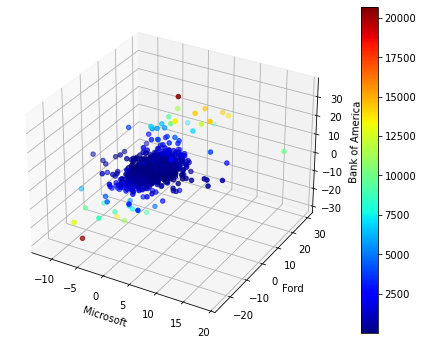

In [11]:
from numpy.linalg import inv

X = delta.to_numpy()
S = covValue.to_numpy()
for i in range(3):
    X[:,i] = X[:,i] - meanValue[i]
    
def mahalanobis(row):
     return np.matmul(row,S).dot(row)
    
anomaly_score = np.apply_along_axis( mahalanobis, axis=1, arr=X)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=anomaly_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

The top-2 anomalies are shown as a brown point in the figure above. 

The highest anomaly corresponds to the day in which the prices for all 3 stocks increase significantly whereas the second highest anomaly corresponds to the day in which all 3 stocks suffer a large percentage drop in their closing prices. 

We can examine the dates associated with the top-2 highest anomaly scores as follows.

In [12]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(2,'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
4/9/2009,2.456295,7.280398,35.235771,20691.465032
10/7/2008,-6.789282,-20.928583,-26.259300,20471.095209


Note that the sharp drop in the stock prices on October 7, 2008 coincide with the beginning of the global financial crisis [Global financial crisis in October 2008](https://en.wikipedia.org/wiki/Global_financial_crisis_in_October_2008) while the increase in the stock prices on April 9, 2009.

Text(0, 0.5, 'Percent Change')

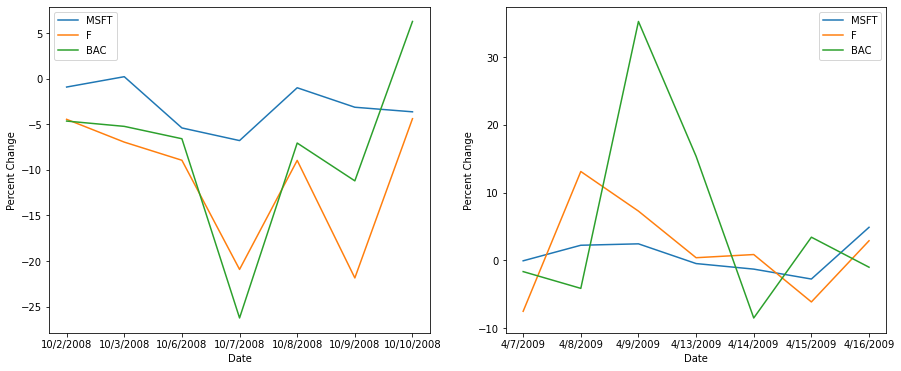

In [13]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ts = delta[440:447]
ts.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts.index)
ax1.set_ylabel('Percent Change')

ts = delta[568:575]
ts.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts.index)
ax2.set_ylabel('Percent Change')

# 9.2 Using Distance-based Approach

This is a model-free anomaly detection approach as it does not require constructing an explicit model of the normal class to determine the anomaly score of data instances.

The example code shown below employs the k-nearest neighbor approach to calculate anomaly score. 

Specifically, a normal instance is expected to have a small distance to its k-th nearest neighbor whereas an anomaly is likely to have a large distance to its k-th nearest neighbor. 

In the example below, we apply the distance-based approach with k=4 to identify the anomalous trading days from the stock market data described in the previous section.

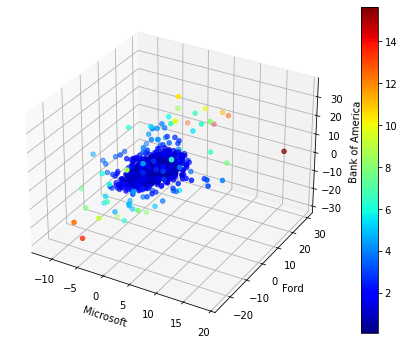

In [28]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance

knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(delta.to_numpy())
distances, indices = nbrs.kneighbors(delta.to_numpy())

anomaly_score = distances[:,knn-1]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=anomaly_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)

plt.show()

The results are slightly different than the one shown in Section 9.1 since we have used Euclidean distance (instead of Mahalanobis distance) to detect the anomalies. 

We can examine the dates associated with the top-5 highest anomaly scores as follows

In [21]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(5,'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
10/13/2008,18.559648,20.039128,9.166457,15.642827
11/26/2008,2.456248,29.456698,4.223406,14.212749
10/7/2008,-6.789282,-20.928583,-26.259300,13.751302
11/28/2008,-1.362724,25.054905,5.280972,13.139586
9/30/2008,6.672314,24.638866,15.669129,12.599739


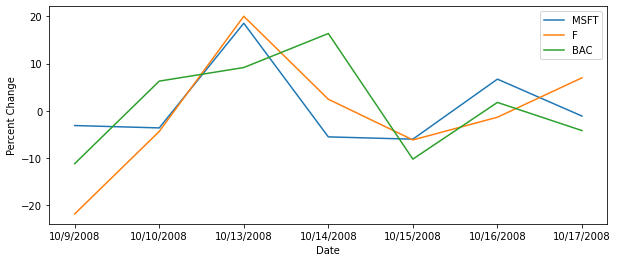

In [26]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ts = delta[445:452]
ts.plot.line(ax=ax)
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change')
plt.show()